# Assignment:  Data Visualization and Visual Analytics

### Khushi Kala

<div class="alert alert-block alert-info blue">
<b>In the following questions we will be working on 3 datasets related to Olympic Games </b>

1. *accidents.geojson* accidents in Kiel between 2016 and 2022. The meaning of most of the fields will be self explanatory. The
field geometry contains the coordinates of the accident. The binary fields (e.g. bike,
pedestrian) indicate whether the respective group was involved in the accident.

2. *districts.geojson* name, polygons and some other information about the districts of Kiel. 

3. *roads.geojson* line representation of road segments in Kiel
    2012
</div>

## 
<div class="alert alert-block alert-warning">
<b>Exercise: 1</b> 
</div>

### Visualizing and describing Patterns

# 1. Data

In [1]:
#Importing Pacakges
import numpy as np
import pandas as pd
import altair as alt
import geopandas as gpd
import matplotlib.pyplot as plt 
import folium 
import mapclassify
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

## 1.1 Geo Data

First, we load the data that we want to visualize on the map. 

In [2]:
#reading geojson file
accident_file = 'accidents.geojson'
accidents_gdf = gpd.read_file(accident_file)

#analysing first 5 rows 
accidents_gdf.head()

year    month  hour    weekday         harm_type  \
0  2016  January     7  Wednesday  Slightly Injured   
1  2016  January    11    Tuesday  Slightly Injured   
2  2016  January     6     Friday  Slightly Injured   
3  2016  January     7    Tuesday  Slightly Injured   
4  2016  January     4     Sunday  Slightly Injured   

                                               type1  \
0           Collision between vehicle and pedestrian   
1  Collision with another vehicle moving laterall...   
2  Collision with another vehicle which starts, s...   
3  Collision with another vehicle which turns int...   
4                           Accident of another kind   

                                               type2 light_conditions bike  \
0               Accident caused by crossing the road         Twilight    0   
1  Accident between vehicles moving along in carr...             None    0   
2                      Accident involving stationary         Twilight    0   
3  Accident caused by turning into a road or by c...         Twilight    0   
4                                   Driving accident         Twilight    0   

  car pedestrian motorcycle truck other                        geometry  
0   1          1          0     0     0  POINT (573159.144 6018353.323)  
1   1          0          0     1     0  POINT (572991.842 6017953.685)  
2   0          0          0     0     1  POINT (574104.830 6018642.713)  
3   1          0          1     0     0  POINT (573294.512 6019242.699)  
4   0          0          1     0     0  POINT (575998.620 6019246.232)

### For our study the description of type1 and type2 accident is irrelevant. We can estimate the harm of accident and then consider it minor or major. 

In [3]:
#dropping columns
accidents_gdf.drop(columns=['type1','type2'], inplace=True)

accidents_gdf

year     month  hour    weekday         harm_type light_conditions bike  \
0     2016   January     7  Wednesday  Slightly Injured         Twilight    0   
1     2016   January    11    Tuesday  Slightly Injured             None    0   
2     2016   January     6     Friday  Slightly Injured         Twilight    0   
3     2016   January     7    Tuesday  Slightly Injured         Twilight    0   
4     2016   January     4     Sunday  Slightly Injured         Twilight    0   
...    ...       ...   ...        ...               ...              ...  ...   
6767  2022  December     7     Monday  Slightly Injured         Twilight    1   
6768  2022  December    17    Tuesday  Slightly Injured         Twilight    1   
6769  2022  December    18     Monday  Slightly Injured         Twilight    1   
6770  2022  December    15   Thursday  Severely Injured             None    0   
6771  2022  December     7     Monday  Slightly Injured         Twilight    0   

     car pedestrian motorcycle truck other                        geometry  
0      1          1          0     0     0  POINT (573159.144 6018353.323)  
1      1          0          0     1     0  POINT (572991.842 6017953.685)  
2      0          0          0     0     1  POINT (574104.830 6018642.713)  
3      1          0          1     0     0  POINT (573294.512 6019242.699)  
4      0          0          1     0     0  POINT (575998.620 6019246.232)  
...   ..        ...        ...   ...   ...                             ...  
6767   0          0          0     0     0  POINT (573628.117 6019416.776)  
6768   1          0          0     0     0  POINT (574259.367 6020007.083)  
6769   0          0          0     0     0  POINT (573557.532 6025810.505)  
6770   1          0          0     0     1  POINT (574694.462 6014594.544)  
6771   1          0          1     0     0  POINT (574222.794 6022108.091)  

[6772 rows x 13 columns]

In [4]:
accidents_gdf.shape

(6772, 13)

In [5]:
accidents_gdf.isnull().sum()

year                   0
month                  0
hour                   0
weekday                0
harm_type              0
light_conditions    5383
bike                   0
car                    0
pedestrian             0
motorcycle             0
truck               1043
other                  0
geometry               0
dtype: int64

### Handling the null values 

In [6]:
#filling nan values in light condition on the basis of time 
accidents_gdf['light_conditions'] = accidents_gdf.apply(lambda row: 'Daylight' if pd.isnull(row['light_conditions']) and row['hour'] >=8 and row['hour'] <=17
                                                         else 'Twilight' if pd.isnull(row['light_conditions']) else
                                                         row['light_conditions'], axis=1)

In [7]:
accidents_gdf.isnull().sum()

year                   0
month                  0
hour                   0
weekday                0
harm_type              0
light_conditions       0
bike                   0
car                    0
pedestrian             0
motorcycle             0
truck               1043
other                  0
geometry               0
dtype: int64

In [8]:
# Since we are not sure that in the case where truck data is missing, it can be possible that it is involve or it is not, therefore we will fill all those values as 0 for our study ahead. 
accidents_gdf.fillna({'truck':'0'}, inplace=True)

In [9]:
accidents_gdf.duplicated().sum()

2

In [10]:
#we will drop the duplicates 
accidents_gdf.drop_duplicates(inplace=True)

In [11]:
#we are only considering main bike and car mode of transportation for our analysis 
accidents_gdf.drop(columns=['truck','other','pedestrian', 'motorcycle'], inplace= True )

### Initial Data Analysis

<Axes: xlabel='year', ylabel='geometry'>

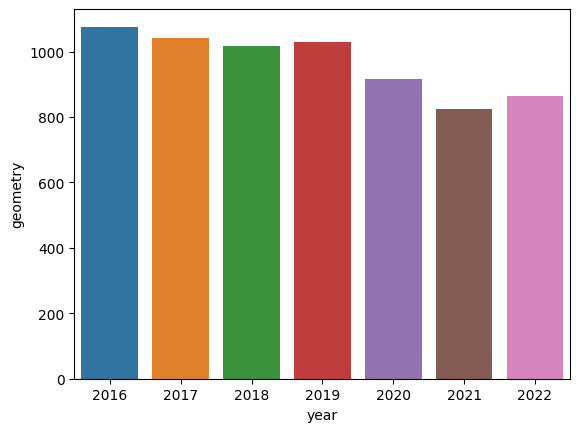

In [12]:
year_accidents = accidents_gdf.groupby('year')['geometry'].agg('count').reset_index()

year_accidents = year_accidents.rename({'geometry':'total_accidents'})

#plotting the graph
sns.barplot(x = 'year', y = 'geometry', data=year_accidents)

### Observation
1. With coming year number of accidents has become less.
2. the year 2016 observed highest accidents cases

In [13]:
#changing data types
accidents_gdf['bike'] = accidents_gdf['bike'].astype(int)
accidents_gdf['car'] = accidents_gdf['car'].astype(int)

In [14]:
vehicle_accidents = accidents_gdf.groupby('year')[['bike','car']].agg('sum').reset_index()
vehicle_accidents

year  bike  car
0  2016   430  848
1  2017   398  855
2  2018   429  788
3  2019   458  782
4  2020   468  680
5  2021   378  607
6  2022   435  593

In [15]:
#merging it with year accidents
merged_year = pd.merge(vehicle_accidents, year_accidents, how='inner', on = 'year')

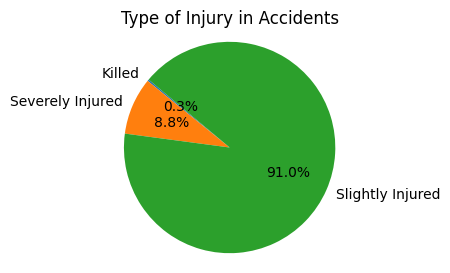

In [17]:
#plotting type of injury
harm_types = accidents_gdf.groupby('harm_type')['geometry'].agg('count').reset_index()

#plotting graph 
plt.figure(figsize=(3, 3))
plt.pie(harm_types['geometry'], labels=harm_types['harm_type'], autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.title('Type of Injury in Accidents')
plt.show()

### Observation
1. More than 90% of the accidents resulted in Slight/Mild Injury
2. Less than 0.5% of the accidents resulted in death
3. Less than 10% of the accidents resulted in severe injury

In [18]:
#monthly aggregation 
monthly_accidents = accidents_gdf.groupby('month')['geometry'].count().reset_index()

#sorting the months 
month_order = ['January','February','March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']

monthly_accidents['month'] = pd.Categorical(monthly_accidents['month'], categories=month_order, ordered=True)

monthly_accidents.sort_values(by='month', inplace=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, 'January'),
  Text(1, 0, 'February'),
  Text(2, 0, 'March'),
  Text(3, 0, 'April'),
  Text(4, 0, 'May'),
  Text(5, 0, 'June'),
  Text(6, 0, 'July'),
  Text(7, 0, 'August'),
  Text(8, 0, 'September'),
  Text(9, 0, 'October'),
  Text(10, 0, 'November'),
  Text(11, 0, 'December')])

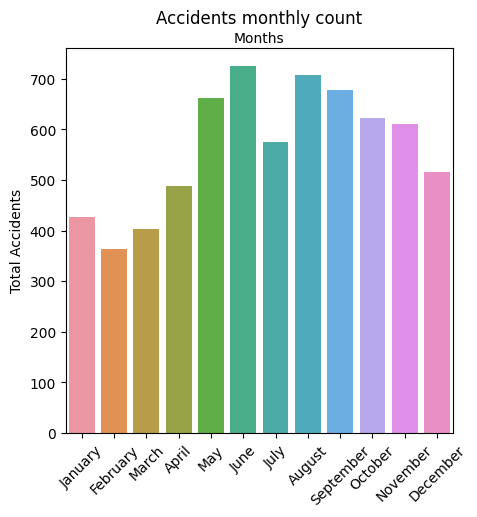

In [19]:
fig, (ax1) = plt.subplots(1,1,figsize = (5,5))


sns.barplot(data=monthly_accidents, x='month', y= 'geometry', ax=ax1)

ax1.set_title('Accidents monthly count')
ax1.set_xlabel('Months')
ax1.set_ylabel("Total Accidents")
ax1.xaxis.set_label_position('top')
plt.xticks(rotation=45) 

### Observation 
1. Highest Accidents are in the month of June and August, It could be due to weather effect or travel purposes.

<Axes: xlabel='light_conditions', ylabel='total_count'>

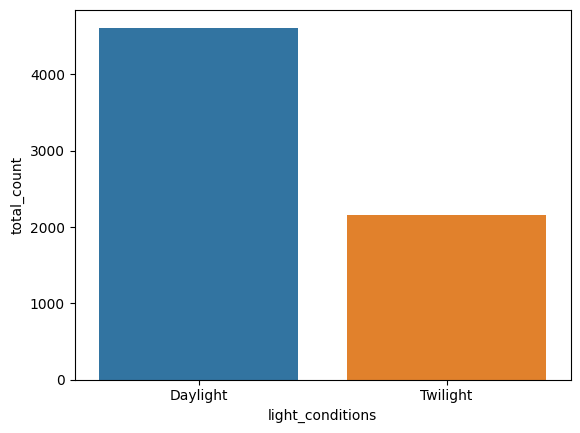

In [20]:
#plotting on the basis of light conditions 
light_group = accidents_gdf.groupby('light_conditions')['geometry'].count().reset_index()

light_group = light_group.rename(columns={'geometry':'total_count'})

sns.barplot(x= 'light_conditions', y= 'total_count', data = light_group)

### Observation
1. Even in daylight, the number of accidents are more
2. This can be due to there are more vehicles busy on road in daylight 

In [21]:
#Importing districts file 
districts_file = 'districts.geojson'
districts_gdf = gpd.read_file(districts_file)
districts_gdf.head()

osmid                     name  wikidata  \
0  968220               Ravensberg  Q1301655   
1  969228             Blücherplatz  Q1740941   
2  969563            Schreventeich   Q978752   
3  969718  Neumühlen-Dietrichsdorf  Q1980942   
4  975405                 Brunswik   Q994177   

                                            geometry  
0  POLYGON ((571612.381 6022507.828, 571637.678 6...  
1  POLYGON ((573501.927 6021467.414, 573534.715 6...  
2  POLYGON ((571214.029 6020668.789, 571270.005 6...  
3  POLYGON ((576053.576 6021226.288, 576017.006 6...  
4  POLYGON ((573348.628 6020944.719, 573341.660 6...

In [22]:
#dropping wikidata column as it is not required 
districts_gdf.drop(columns='wikidata', inplace = True)

In [23]:
districts_gdf.shape

(30, 3)

In [24]:
districts_gdf.duplicated().sum()

0

In [25]:
districts_gdf.isnull().sum()


osmid       0
name        0
geometry    0
dtype: int64

In [26]:
#renaming the id column 
districts_gdf.rename(columns={'osmid':'district_id'}, inplace = True)

In [27]:
#importing data for road geodata 
road_file = 'roads.geojson'
road_gdf = gpd.read_file(road_file)

#analysing first 5 rows

road_gdf.head()



osmid          name    road_type   wikidata  \
0  4015605   Jaegerallee  residential       None   
1  4015606   Kanalstraße  residential  Q62055650   
2  4015609   Kanalstraße  residential  Q62055650   
3  4015610  Strandstraße  residential       None   
4  4015611  Zum Oberland  residential       None   

                                            geometry  
0  LINESTRING (573742.242 6025230.522, 573700.284...  
1  LINESTRING (573641.893 6025156.569, 573649.285...  
2  LINESTRING (574912.368 6025293.008, 574912.862...  
3  LINESTRING (574869.582 6025292.797, 574873.572...  
4  LINESTRING (575116.783 6025658.171, 575099.256...

In [28]:
road_gdf.isnull().sum()

osmid           0
name          215
road_type       0
wikidata     4274
geometry        0
dtype: int64

In [29]:
# we will drop those street whose name are not present in our dataset 
road_gdf.dropna(subset=['name'], inplace=True)

In [30]:
#the wikidata column is invalid, we will drop that column
road_gdf.drop(columns='wikidata', inplace=True)

In [31]:
road_gdf.duplicated().sum()

0

In [32]:
road_gdf.rename(columns={'osmid':'road_id'}, inplace=True)

### For further analysis, will maintain two goups such that we can identify pattern on the basis of following points.
Dividing the Data into two groups with time series => 2017-2019 and 2020-2022

In [33]:
### data containing only years 2017 and 2018, mentioning it as previous data

previous_accident_gdf = accidents_gdf[accidents_gdf['year'].between(2017, 2019)]

### data containing only years 2019, 2020, 2021 and 2022 mentioning it as recent data

recent_accident_gdf = accidents_gdf[accidents_gdf['year'].between(2020, 2022)]

### Geodata Visualization 

### Analysis to be perform 
1. Number of Accidents per district 
2. Type of Accident Analysis  (Mild and Severe)
3. Roads which has most frequent accidents 

By analysing this we can find some pattern and then we can deduce a recommendation 

### 1. Number of Accidents per district 

### Plotting District Map 

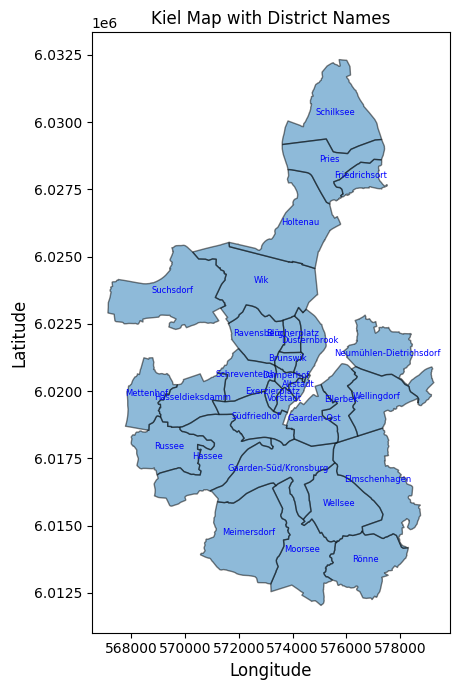

In [34]:
#Plotting the District Graph 

fig, ax = plt.subplots(figsize=(12, 7))  # Adjust the figure size as needed

# Plot the district boundaries
districts_gdf.plot(ax=ax, edgecolor='black', alpha=0.5)

# Add district names as annotations
for idx, row in districts_gdf.iterrows():
    ax.text(row.geometry.centroid.x, row.geometry.centroid.y, row['name'],
            horizontalalignment='center', fontsize=6, color='blue')

# Set labels and title
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
ax.set_title('Kiel Map with District Names', fontsize=12)


# Show the map
plt.tight_layout()
plt.show()

### Observation
1. There are total 30 districts in Kiel city of Germany 

### Plotting Kiel Map over Germany

In [35]:
#creating Kiel Map 
latitude_Kiel = 54.32
longitude_Kiel = 10.12 
kiel_map= folium.Map(location=[latitude_Kiel, longitude_Kiel], zoom_start=11, height=500, width=1000, tiles='CartoDB positron')

#adding tooltip
tooltip = folium.features.GeoJsonTooltip(fields=['name'], 
                                          aliases=["District Name"],
                                        labels=True,
                                        stick=False)

# Add district data to the folium map
folium.GeoJson(districts_gdf, tooltip=tooltip).add_to(kiel_map)

#displaying map
kiel_map

### Plotting Accidents Maps

In [36]:
def create_folium(gdf, color):

    #creating folium graph 
    m = folium.Map(location=[latitude_Kiel,longitude_Kiel], zoom_start=11, tiles='CartoDB positron', height=500, width=1000)

    tooltip = ['year','light_conditions']

    return  gdf.explore(
        m=m,                                  
        column="harm_type",             
        tooltip=tooltip,            
        popup=['year', 'light_conditions'],  
        cmap="viridis",                       
        scheme='Quantiles',              
        style_kwds=dict(color=color)    
    )


In [37]:
#Now analysing the pattern of Accidents by plotting a map for year 2016-2018
create_folium(previous_accident_gdf, "orange")


In [38]:
# Now analysing the pattern of Accidents by plotting a map for year 2019-2022
create_folium(recent_accident_gdf, "green")

### Observation
1. Not much difference can be infer from present and last three years geodata
2. We can conclude that the intial grpahical representation of accidents are similar on a large scale. Since districts are same

### 1. Counting number of accidents per district

In [39]:
#accidents_gdf' contains points with accidents data and 'districts_gdf' contains polygons of districts

# Perform a spatial join to associate accidents with districts
accidents_in_districts = gpd.sjoin(previous_accident_gdf, districts_gdf, how='left', predicate='within')

# Grouping by district and counting the number of accidents in each district
district_accident_count = accidents_in_districts.groupby('district_id').size().reset_index(name='accident_count')

# Merging the counts with districts GeoDataFrame
districts_with_count_2017 = districts_gdf.merge(district_accident_count, on='district_id', how='left')


In [40]:
#displaying top 5 districts with highest accidents 
top_5_accidents_2017 = districts_with_count_2017.sort_values(by='accident_count', ascending=False).head(5)

In [41]:
def create_accident_count_map(gdf, fillcolor):
    m = folium.Map(location=[latitude_Kiel, longitude_Kiel], zoom_start=12) 
    folium.Choropleth(
        geo_data=gdf,
        data=gdf,
        columns=['district_id', 'accident_count'],
        key_on='feature.properties.district_id',
        fill_color=fillcolor,
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_kwds={"loc": "center left", "bbox_to_anchor": (1, 0.5), "fmt": "{:.0f}"},
        get_legend = gdf['name'],
        legend_name='Accidents Count',
    ).add_to(m)

    folium.TileLayer("CartoDB positron", show=False).add_to(
        m
    )  

    return m  

In [42]:
create_accident_count_map(districts_with_count_2017, "YlOrRd")

### Observation
1. The highest number of accidents is in the district of Sudfriedhof,GaardenOst, Schreventeich, Kronsburg and in the center. 
2. This can be due to fact of more movement and busy area near these places.

In [43]:
accidents_in_districts_2022 = gpd.sjoin(recent_accident_gdf, districts_gdf, how='left', predicate='within')

# Grouping by district and counting the number of accidents in each district
district_accident_count_2022 = accidents_in_districts_2022.groupby('district_id').size().reset_index(name='accident_count')

# Merging the counts with districts GeoDataFrame
districts_with_count_2022= districts_gdf.merge(district_accident_count_2022, on='district_id', how='left')

#displaying top 5 districts with highest accidents 
top_5_accidents_2022 = districts_with_count_2022.sort_values(by='accident_count', ascending=False).head(5)

In [44]:
create_accident_count_map(districts_with_count_2022, "Blues")

### Observation
1. Again The highest number of accidents is in the district of Sudfriedhof,GaardenOst, Schreventeich, Kronsburg and in the center. 


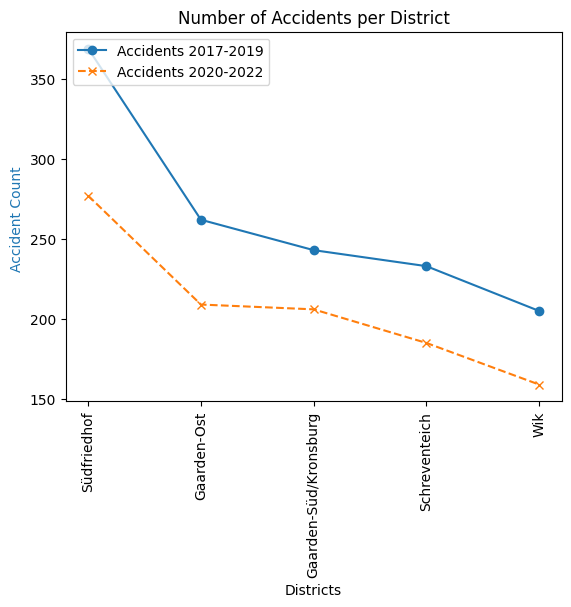

In [45]:
#Plotting both the graphs together 
# Plotting
fig, ax1 = plt.subplots(sharey= True)
ax1.plot(top_5_accidents_2017['name'], top_5_accidents_2017['accident_count'], label=f'Accidents 2017-2019', marker='o')
ax1.plot(top_5_accidents_2017['name'], top_5_accidents_2022['accident_count'], label=f'Accidents 2020-2022', linestyle='--', marker='x')
ax1.set_xlabel('Districts')
ax1.set_xticklabels(rotation=90 , labels= top_5_accidents_2022['name'])
ax1.set_ylabel('Accident Count ', color='tab:blue')
plt.title('Number of Accidents per District')
ax1.legend(loc='upper left')
plt.show()

### Observation
1. The number of accidents has become less in coming years.


### 2. Plotting Accidents on the Basis of Harm types

In [46]:
def creating_singleHarmType_selection(gdf):
    harm_types = np.array(gdf['harm_type'].unique())

    #creating a single selection bound to a drop-down menu.

    selectHarmType = alt.selection_single(
        name='Select', # name the selection 'Select'
        fields=['harm_type'], 
        # bind='legend'# limit selection to the Major_Genre field
        # value={'harm_type': harm_types[0]}, # use first genre entry as initial value
        bind=alt.binding_select(options=harm_types) # bind to a menu of unique genre values
    )

    return alt.Chart(gdf).mark_bar().add_selection(
        selectHarmType
    ).encode(
        x='year:N',
        y='count(year):Q',
        tooltip='month:N',
        color=alt.condition(selectHarmType, 'harm_type:N', alt.value('lightgray'))
    ) 

In [47]:
#single selection for previous years
creating_singleHarmType_selection(previous_accident_gdf)

alt.Chart(...)

In [48]:
creating_singleHarmType_selection(recent_accident_gdf)

alt.Chart(...)

### Observation:
1. In both the groups the number of slightly injured people is always more than the major injured people.


### Plotting these harmtypes geo map 

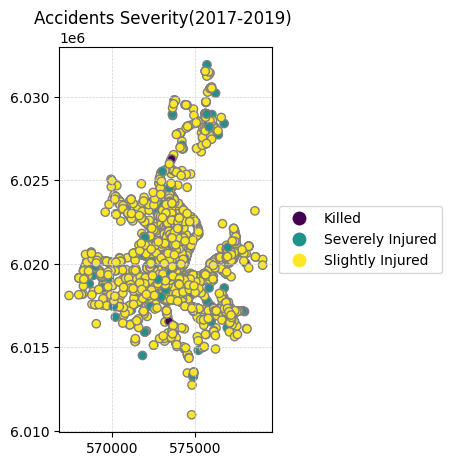

In [49]:
ax = previous_accident_gdf.plot(
column="harm_type",
legend=True,
cmap="viridis",
figsize=(13,5),
edgecolor="grey",
legend_kwds={"loc": "center left", "bbox_to_anchor": (1, 0.5), "fmt": "{:.0f}"})

ax.set_title("Accidents Severity(2017-2019) ", fontsize=12);
ax.grid(True, color="lightgrey", linestyle="--", linewidth=0.5);



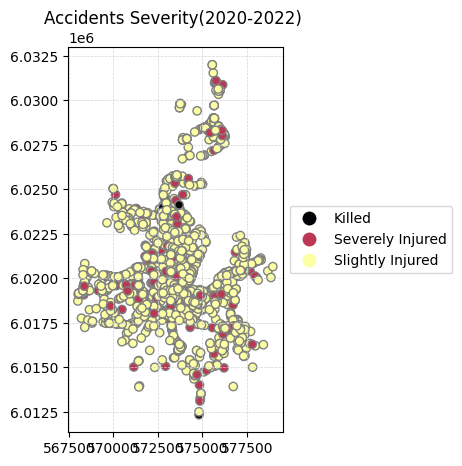

In [50]:
ax = recent_accident_gdf.plot(
    column="harm_type",
    legend=True,
    cmap="inferno",
    figsize=(13,5),
    edgecolor="grey",
    legend_kwds={"loc": "center left", "bbox_to_anchor": (1, 0.5), "fmt": "{:.0f}"},
  )

ax.set_title("Accidents Severity(2020-2022) ", fontsize=12);
ax.grid(True, color="lightgrey", linestyle="--", linewidth=0.5);

### Observation
1. We can observe that slightly injured accidents happens in overall districts on a large basis

### Plotting Road map on District map

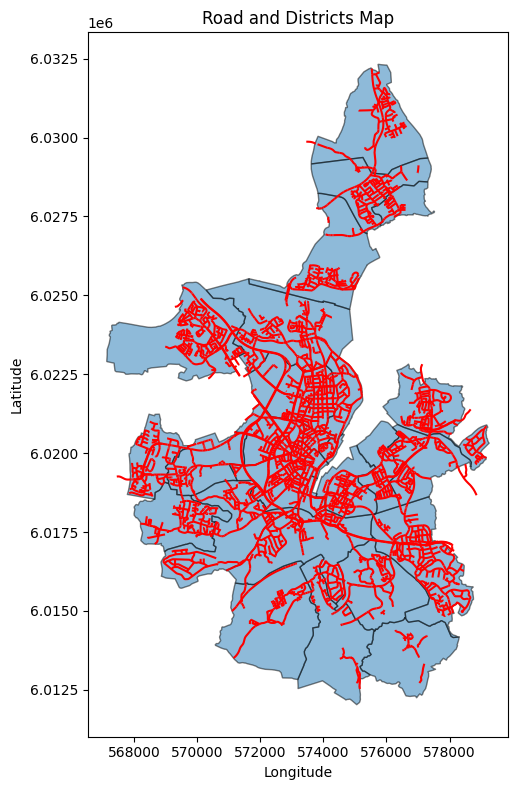

In [51]:
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the district boundaries with a specific color and edgecolor
districts_gdf["geometry"].plot(ax=ax, edgecolor='black', alpha=0.5)

road_gdf["geometry"].plot(ax=ax, color="red", markersize=10)

# Set labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Road and Districts Map')

# Show the plot
plt.tight_layout()
plt.show()


### Observation 
1. We can see there are maximum roads in the areas where before we have found maximum accidents, thus it totally fits to the general idea that busiest road area are likely to have more accidents 

### 3. Road accident count 

In [65]:
accidents_in_roads_2017 = gpd.sjoin_nearest(previous_accident_gdf, road_gdf, max_distance=10)

# Grouping by district and counting the number of accidents in each district
road_accident_count_2017 = accidents_in_roads_2017.groupby('road_id').size().reset_index(name='accident_count')

# Merging the counts with districts GeoDataFrame
road_with_count_2017= road_gdf.merge(road_accident_count_2017, on='road_id', how='left')

#displaying top 5 districts with highest accidents 
top_5_road_accident_2017 = road_with_count_2017.sort_values(by='accident_count', ascending=False).head(5)

top_5_road_accident_2017

road_id                name  road_type  \
1435   28219811  Theodor-Heuss-Ring  secondary   
2009   39942534     Preetzer Straße   tertiary   
1556   30497437  Hamburger Chaussee  secondary   
2559  151702273        Sophienblatt  secondary   
3064  314450783     Preetzer Straße   tertiary   

                                               geometry  accident_count  
1435  LINESTRING (573949.071 6017832.281, 573970.050...            18.0  
2009  LINESTRING (575575.023 6018053.085, 575576.369...            14.0  
1556  LINESTRING (571563.071 6016645.530, 571566.377...            14.0  
2559  LINESTRING (573367.480 6018735.397, 573372.731...            14.0  
3064  LINESTRING (574123.406 6018333.430, 574135.788...            13.0

In [66]:
accidents_in_roads_2022 = gpd.sjoin_nearest(recent_accident_gdf, road_gdf, max_distance=10)

# Grouping by district and counting the number of accidents in each district
road_accident_count_2022 = accidents_in_roads_2022.groupby('road_id').size().reset_index(name='accident_count')

# Merging the counts with districts GeoDataFrame
road_with_count_2022= road_gdf.merge(road_accident_count_2022, on='road_id', how='left')

#displaying top 5 districts with highest accidents 
top_5_road_accident_2022 = road_with_count_2022.sort_values(by='accident_count', ascending=False).head(5)

top_5_road_accident_2022

road_id                name  road_type  \
2559  151702273        Sophienblatt  secondary   
2009   39942534     Preetzer Straße   tertiary   
2541  150022658  Theodor-Heuss-Ring      trunk   
3087  314751039             Ostring    primary   
3064  314450783     Preetzer Straße   tertiary   

                                               geometry  accident_count  
2559  LINESTRING (573367.480 6018735.397, 573372.731...            14.0  
2009  LINESTRING (575575.023 6018053.085, 575576.369...            13.0  
2541  LINESTRING (573176.824 6017864.899, 573214.605...            12.0  
3087  LINESTRING (575206.408 6018894.818, 575230.085...            11.0  
3064  LINESTRING (574123.406 6018333.430, 574135.788...            11.0

### Recommendations
1. From our analysis we can see that the areas where roads are more and it is near to center have highest accidents
2. We can observed it reasons, so actions can be taken to make more strict rules and higher precision in traffic handling.
3. We observd that in daylight accidents occur more. Thus more awareness has to be spread
4. We observed that month of June and August has shown highest accidents, thus the reason behind it must be more commuter and travellers. Thus steps must be taken to improve this pattern of accident and make it more less with coming years.
